The aim of this project was to develop a machine learning technique of supervised classification of time series. The technique would then be applied to light curves (photon count rate against time) of a black hole x-ray binary system GRS1915+105. Its light curves show about a dozen classes of activity, with unique trends of high/low count rate intervals, peaks and periods of quiescence. A better understanding of the evolution of the source over time will give us insights into the undelying accretion physics.

Since many of the GRS1915 light curves show features with characteristic shapes, and the classes of source activity can be labeled based on those, a shapelet based classification algorithm was developed, which finds the most meaningful shapes within the time series. It was inspired by the work of Ye, L. and Keogh, E.; "Time series shapelets: a new primitive for data mining", Proceedings of the 15th ACM SIGKDD international conference on Knowledge discovery and data mining, 2009. 

Shapelets are fragments of the time series. They come with the same classification labels as the original time series, and new time series are classified based on the minimal euclidean distances to those shapelets. This notebook contains an example application of the algorithm to a set of artificial time series.

In [79]:
import shapelets as sha
import ts_generator
import importlib
importlib.reload(sha)
importlib.reload(ts_generator)

%matplotlib inline
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
random.seed(0)
np.random.seed(0)

First a set of time series  was generated. The ts_generator function creates time series of six classes, each containing characteristic shapes at random positions and with random noise added. Each class was visualised below.
The time series were also split into training and test sets. 

Terminology clarification: time series was used interchangebly with light curves, state is equivalent to class/classification/label.

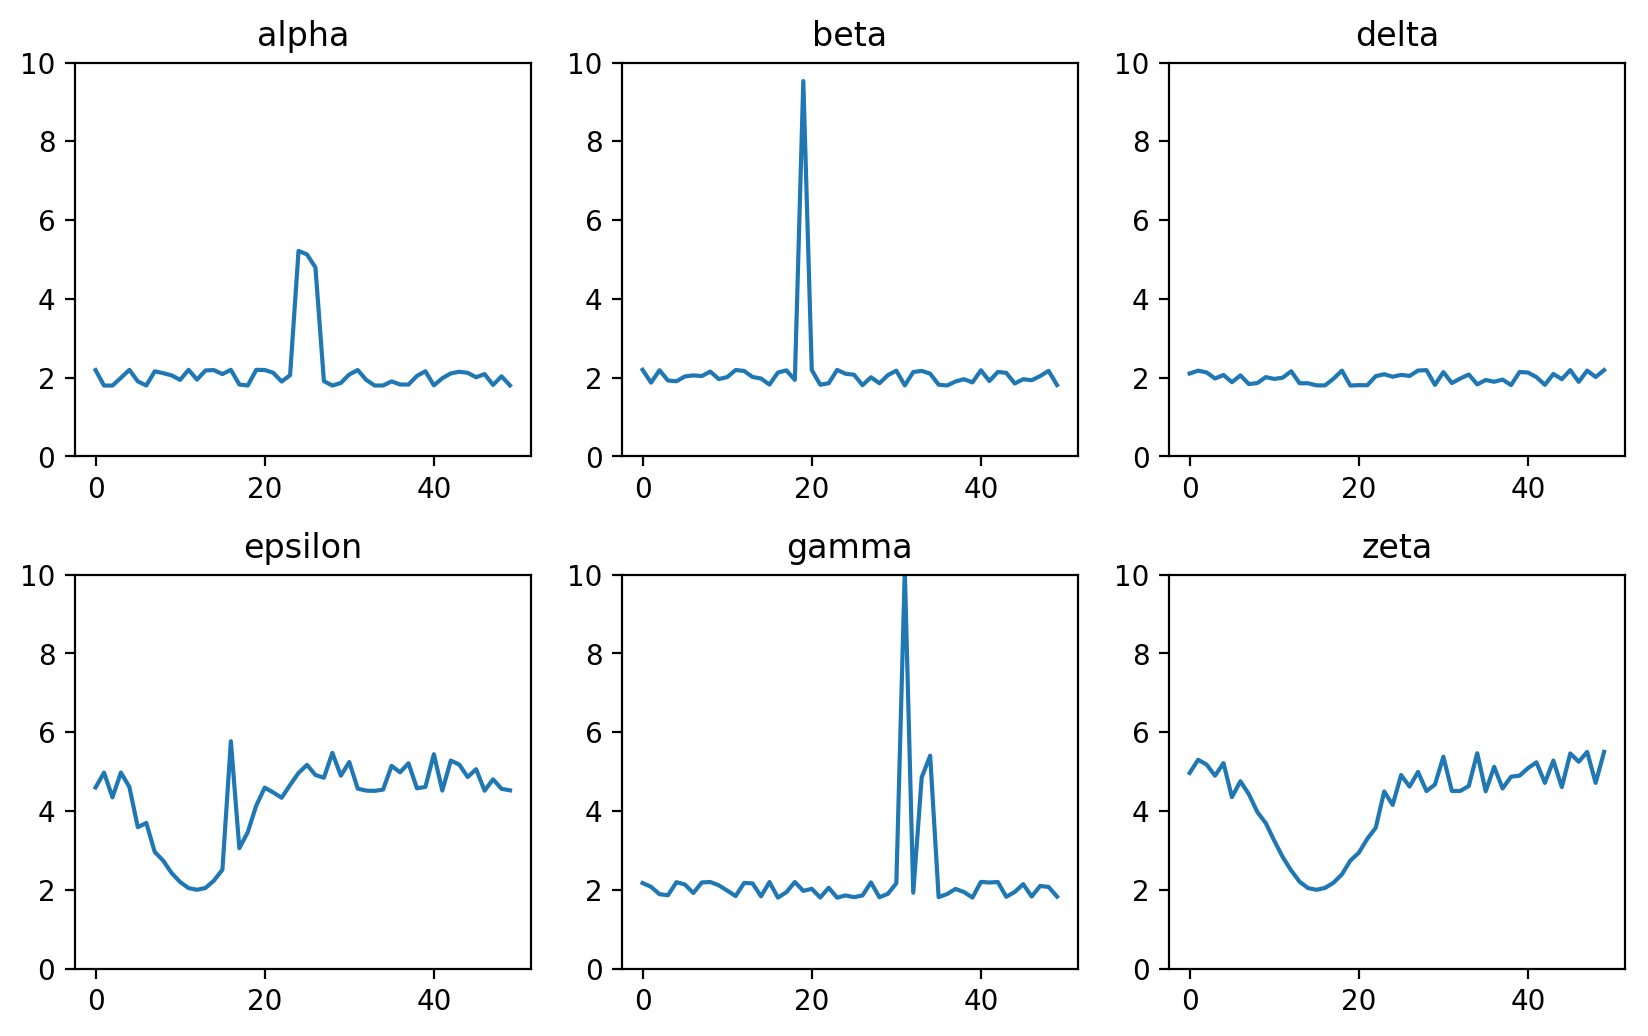

In [80]:
# number of time series of every class to be generated and the length of a time series
no_per_class=20
lc_len=50
lcs, classes = ts_generator.generate(no_per_class,lc_len)
#id numbers for the time series
ids=list(range(len(classes)))  
#stratified split into training and test sets, 50:50 ratio, xs are the data, ys are the labels/classes
x_train, x_test, y_train, y_test, id_train, id_test = train_test_split(lcs, classes, ids, test_size=0.5, random_state=0, stratify=classes)

plt.figure(figsize=(10,6), dpi=200)
plt.subplots_adjust(hspace=0.3)
for n, name in enumerate(sorted(list(set(classes)))):
    plt.subplot(2,3,n+1)
    plt.ylim(0,10)
    plt.title("{}".format(name))
    id_no=np.where(np.array(y_train)=="{}".format(name))[0][0]
    plt.plot(x_train[id_no][0], x_train[id_no][1])
plt.show()

The time series were then fed to the actual shapelets algorithm, which finds the most representative shapelets for each class of time series. It worked as follows:
* For every time series in the training set, all possible subsegments were generated. 
* Then for every subsegment, distances to every time series were calculated, and the time series were ordered according to that distance. 
* Then a threshold value was found, which produced the most homogenous subsets on either side. In an ideal case example, for a shapelet of class alpha, all of the alpha time series would produce distances smaller than the threshold value, and all other time series would produce distances larger thant that value.
* Entropy of subsets quantified their heterogeneity, and the reduction in entropy after a split was quantified as the information gain. Thus the algorithm saved shapelets and threshold values (i.e. split points) which maximised this gain.
* Since the distance calculations between every pair of shapelets and time series was computationally intensive, early abandon and entropy pruning mechanism were introduced, as described by Ye and Keogh.
* The final result was a list of the best shapelet extracted from each training time series.

In [81]:
best_shapelets=[]
time_res=1
for n_donor, lc_donor in enumerate(x_train):
    #Create lists with classifications of all time-series relative to the donor time series; one that the pool of shapelets is generated from
    state_donor = y_train[n_donor]
    belong_class=[]
    other_class=[]
    for n, i in enumerate(id_train):
        if y_train[n] == state_donor:
            belong_class.append(i)
        else:
            other_class.append(i)
    #calculate the entropy of the entire set, so it can be compared to the split set later
    prop_belong = len(belong_class)/(len(belong_class)+len(other_class))
    set_entropy = -(prop_belong)*math.log(prop_belong, 2)-(1-prop_belong)*math.log(1-prop_belong, 2)
    pool=sha.generate_shapelets(lc_donor, 1, len(lc_donor[0]))#generate shapelets from the donor time-series, 
    #set the initial best value of information gain to 0 (improved by any split) and start testing the shapelets
    best_gain=0
    for shapelet in pool:
        skip_shapelet=False#for entropy pruning
        #set the order of distance calculations
        #pick an other_class object first and then alternate between belong and other, when one group runs out, append the rest to the end
        order=[]
        if len(belong_class)<len(other_class):alternations=len(belong_class);larger_group=other_class
        else: alternations=len(other_class); larger_group=belong_class
        for i in range(alternations):
            order.append(other_class[i])
            order.append(belong_class[i])
        for i in range(len(larger_group)-alternations):
            order.append(larger_group[-(i+1)])
        #start distance calculations
        distances=[]
        for n_lc in order:
            if id_train[n_donor] == n_lc:
                distance = 0
            else:
                lc=x_train[np.where(np.array(id_train)==n_lc)[0][0]]
                distance=sha.distance_calculation(shapelet, lc, early_abandon=False)
            #save the distance value together with the classification and lightcurve id
            if n_lc in belong_class:
                class_assign=1
            else:
                class_assign=0
            distances.append((n_lc ,distance, class_assign))
            #find the optimal split point if there are at least two distances calculated, then use entropy pruning to find if the shapelet still has a change to beat the best one found so far
            if len(distances)>1:
                best_split=sha.best_split_point(distances, set_entropy)
                skip_shapelet=sha.entropy_pruning(best_gain, distances, best_split, len(belong_class), len(other_class), set_entropy)
                if skip_shapelet==True:
                    break
        #if shapelet was not rejected at entropy pruning, calculcate the information gain and if the value is larger then the best one so far, save the shapelet
        if skip_shapelet==False:
            gain=sha.information_gain(distances, set_entropy, best_split)
            if gain>best_gain:
                best_gain=gain
                best_shapelet=shapelet
    best_shapelets.append((best_shapelet, best_split, best_gain, id_train[n_donor], state_donor))

Distances between the best set of shapelets and the time series were calculated. Those distances were then used as features for fitting of a decision tree classifier.
The classifier was then used on distances calculated for the test set.

In [82]:
#calculate the minimal distances between the best shapelets and the training time series
train_dists=np.zeros((len(x_train),len(best_shapelets)))
for i_t, t in enumerate(x_train):
    for i_s, s in enumerate(best_shapelets):
        distance=sha.distance_calculation(s[0], t, early_abandon=False)
        train_dists[i_t,i_s]=distance

#calculate the minimal distances between the best shapelets and the test time series
test_dists=np.zeros((len(x_test),len(best_shapelets)))
for i_t, t in enumerate(x_test):
    for i_s, s in enumerate(best_shapelets):
        distance=sha.distance_calculation(s[0], t, early_abandon=False)
        test_dists[i_t,i_s]=distance

#fit a decision tree to the training distances and predict the classification of training time series
dtc=tree.DecisionTreeClassifier(criterion="entropy")
dtc.fit(train_dists, y_train)
train_inference= dtc.score(train_dists, y_train)
print("training inference score:\n",train_inference)

#use the tree to predict the classification of test time series
inference= dtc.predict(test_dists)
print("test inference score:\n",dtc.score(test_dists, y_test))

training inference score:
 1.0
test inference score:
 1.0


The score indicated that over 90% of the test time series were classified correctly. The misclassified time series were printed below.

In [83]:
misclas=[]
for n, classification in enumerate(inference):
    if classification != y_test[n]:
        misclas.append(n)
        print("Observation of class {} (Index:{}) misclassified as {}".format(y_test[n], n, classification))
        #plt.plot(x_test[n][0],x_test[n][1])
        #plt.show()

The decision tree was visualised below. The X<sub>n</sub> values are the features (distances) used to make a decision at every node, whilst the value list shows the number of time series of each class which passed to that node.

['alpha' 'beta' 'delta' 'epsilon' 'gamma' 'zeta']


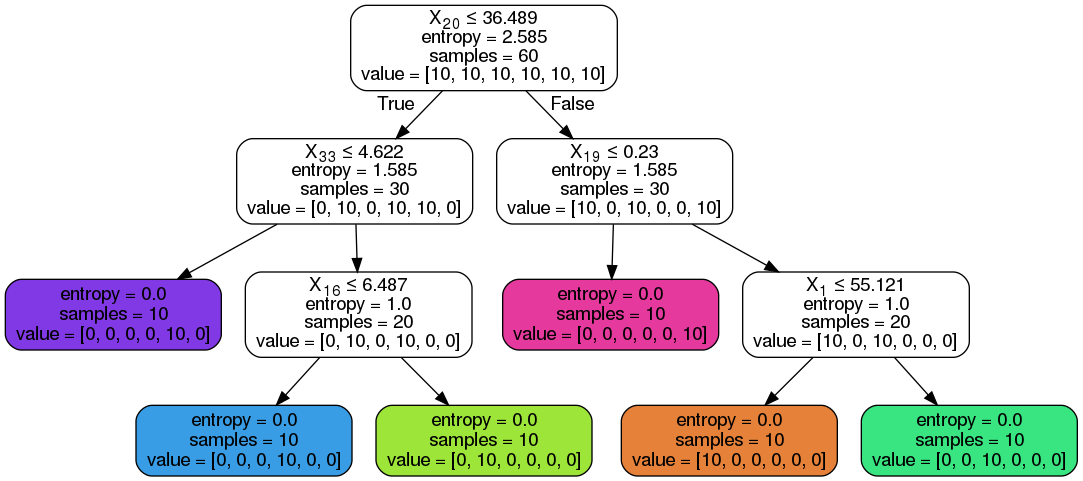

In [84]:
# The "value" list shows classes in the same order as dtc.classes_
print(dtc.classes_)
# visualise the decision tree
dot_data = StringIO()
export_graphviz(dtc, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

The shapelets which produced the distances used as features by the decision tree classifier, plotted on top of their time series of origin.

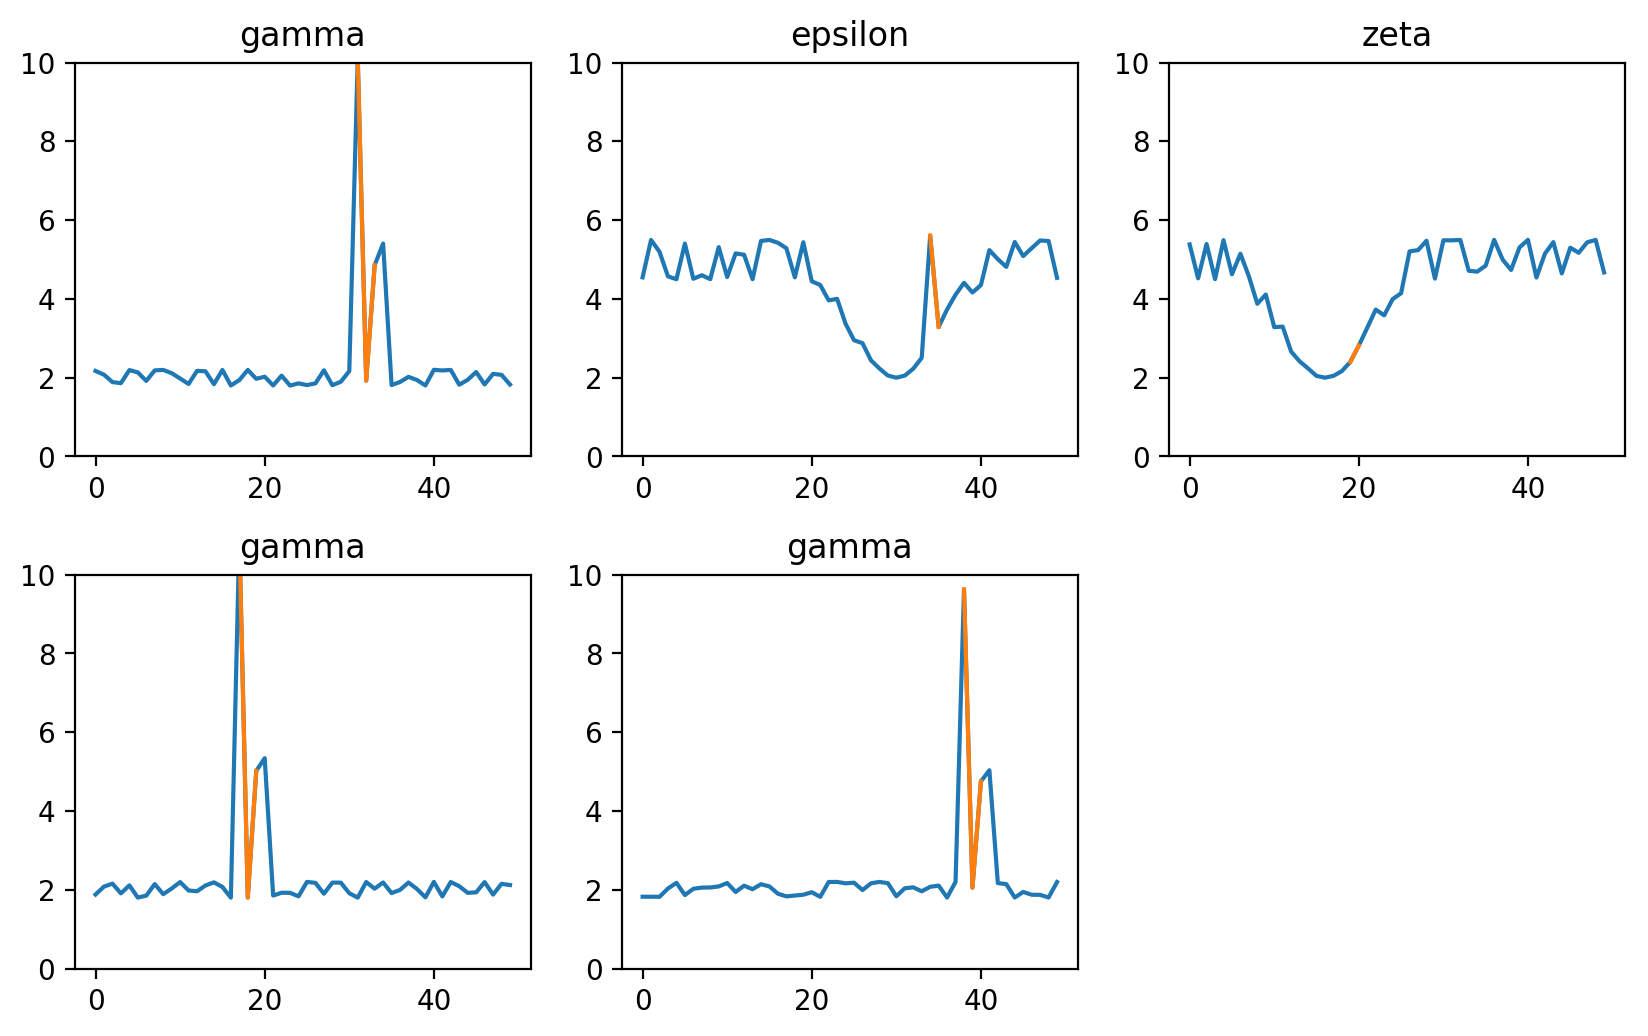

In [85]:
rules=np.where(dtc.feature_importances_>0)[0]
plt.figure(figsize=(10,6),dpi=200)
plt.subplots_adjust(hspace=0.3)
for r, rule in enumerate(rules):
    rule_start=np.where(x_train[rule][1]==best_shapelets[rule][0][0])[0][0]
    rule_xs=np.arange(rule_start,rule_start+len(best_shapelets[rule][0]), 1)
    plt.subplot(2,3,r+1)
    plt.ylim(0,10)
    plt.title("{}".format(best_shapelets[rule][4]))
    plt.plot(x_train[rule][0], x_train[rule][1])
    plt.plot(np.array(rule_xs), best_shapelets[rule][0])
plt.show()